# Kalman Filter 적용 전과 후 스푸핑 공격 감지 정확도 비교 실험

분산이 큰 형태로 수신되는 RSSI 값들을 노이즈 제거에 효과적이고 지속적으로 변화하는 RSSI 값에 이상적인 Kalman Filter를 이용해 필터 작업을 수행한 후 IQR 방식을 이용해 이상적인 RSSI 이상치 값의 범위를 설정한다.

이후 스푸핑 공격에 대해서 Kalman Filter를 적용했을 때의 감지 정확도와 하지 않았을 때의 감지 정확도를 비교한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Kalman Filter
class KalmanFilter():
    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI
    
kf = KalmanFilter(processNoise=0.0005,measurementNoise=20)

In [3]:
# Check incoming RSSI value in IQR range only
class IQRonly():
    def __init__(self):
        self.rssi_arr = []
        
    # Resize RSSI array (Prevent overflow)
    def full_arr(self):
        del self.rssi_arr[:len(self.rssi_arr) - 100]

    # Check incoming RSSI value in IQR range
    def check_val(self, min, max, val):
        if min < val < max:
            return 0
        else:
            if val < min:
                return min - val
            else:
                return val - max    

    def add_rssi(self, rssi):
        if len(self.rssi_arr) > 10000:
            self.full_arr()

        self.rssi_arr.append(rssi)

    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_rssi(self, curr, prev):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        curr_val = self.check_val(min, max, curr)
        prev_val = self.check_val(min, max, prev)

        if curr_val == 0 and prev_val == 0:
            # Not Spoofing Attack
            return False
        else:
            # Spoofing Attack
            return True
        
    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_iqr (self):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        print("IQR :", IQR)
        print("Min RSSI :", min)
        print("Max RSSI :", max)

In [4]:
# Check incoming RSSI value in IQR range with Kalman Filter
class IQRwithKF():
    def __init__(self):
        self.rssi_arr = []
        self.kf = KalmanFilter(processNoise=1, measurementNoise=1)
        
    # Resize RSSI array (Prevent overflow)
    def full_arr(self):
        del self.rssi_arr[:len(self.rssi_arr) - 100]

    # Check incoming RSSI value in IQR range
    def check_val(self, min, max, val):
        if min < val < max:
            return 0
        else:
            if val < min:
                return min - val
            else:
                return val - max    

    def add_rssi(self, rssi):
        if len(self.rssi_arr) > 10000:
            self.full_arr()

        self.rssi_arr.append(self.kf.applyFilter(rssi))

    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_rssi(self, curr, prev):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        curr_val = self.check_val(min, max, curr)
        prev_val = self.check_val(min, max, prev)

        if curr_val == 0 and prev_val == 0:
            # Not Spoofing Attack
            return False
        else:
            # Spoofing Attack
            return True
        
    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_iqr (self):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        print("IQR :", IQR)
        print("Min RSSI :", min)
        print("Max RSSI :", max)

### Data
* Anchor Point (AP)로부터 약 0.5m 떨어진 지점에서 정상 BLE 장치의 비콘 메시지 수집
* 약 10000 (= 1000 * 10)개의 데이터 수집

### Progress
* 각각의 정상 BLE 장치의 비콘 메시지가 들어온 후
* Anchor Point (AP)로부터 서로 다른 거리로부터 들어오는 스푸핑 공격이 있다고 가정
* 이때 Anchor Point (AP)로 수신되는 비콘 메시지의 RSSI 값들을 Kalman Filter를 이용해 필터링 작업 후 IQR 방식을 이용해 이상치 기준 범위를 설정

In [5]:
# Read Data Files
files = []
df_rssi_iqr = []
df_rssi_iqr_kf = []

for i in range(1,10):
    file = './data/gal_data' + str(i) + '.csv'
    files.append("File " + str(i))
    
    tmp = pd.read_csv(file)
    tmp_rssi = tmp['rssi']
    
    tmp_IQRonly = IQRonly()
    tmp_IQRwithKF = IQRwithKF()
    
    for d in tmp_rssi:
        tmp_IQRonly.add_rssi(d)
        tmp_IQRwithKF.add_rssi(d)
    
    df_rssi_iqr.append(tmp_IQRonly)
    df_rssi_iqr_kf.append(tmp_IQRwithKF)
    
    print('-'*50)
    print("File :", file)
    print("Number of Beacon Message :", tmp.shape[0])
    print("Average RSSI :", np.mean(tmp_rssi))
    print("\n( Only IQR )")
    tmp_IQRonly.check_iqr()
    print("\n( IQR & KF )")
    tmp_IQRwithKF.check_iqr()

--------------------------------------------------
File : ./data/gal_data1.csv
Number of Beacon Message : 1002
Average RSSI : -65.47604790419162

( Only IQR )
IQR : 4.5
Min RSSI : -71.5
Max RSSI : -59.5

( IQR & KF )
IQR : 3.1946366861529327
Min RSSI : -69.61211714853997
Max RSSI : -61.09308598546548
--------------------------------------------------
File : ./data/gal_data2.csv
Number of Beacon Message : 1002
Average RSSI : -65.31037924151697

( Only IQR )
IQR : 4.125
Min RSSI : -70.875
Max RSSI : -59.875

( IQR & KF )
IQR : 2.557846373094172
Min RSSI : -68.5927543497022
Max RSSI : -61.77183068811774
--------------------------------------------------
File : ./data/gal_data3.csv
Number of Beacon Message : 1002
Average RSSI : -65.23952095808383

( Only IQR )
IQR : 6.0
Min RSSI : -73.0
Max RSSI : -57.0

( IQR & KF )
IQR : 3.7151076286023397
Min RSSI : -70.06420972655663
Max RSSI : -60.15725605028372
--------------------------------------------------
File : ./data/gal_data4.csv
Number of B

### Anchor Point (AP)로부터 거리에 따른 전반적인 RSSI 값
* 0cm = -38
* 10cm = -48
* 25cm = -57
* 50cm = -64
* 1m = -72

In [6]:
# Different RSSI Value depending on the Distance
# Create Custom Spoofing Data
spoof_distance = ['0cm', '10cm', '25cm', '50cm', '1m']
spoof_data = [-38, -48, -57, -64, -72]

In [7]:
# Check Detection Accuracy (only IQR)
acc_arr_iqr = []

for i in range(5):
    acc = []
    for j in range(9):
        acc.append(df_rssi_iqr[j].check_rssi(spoof_data[i], df_rssi_iqr[j].rssi_arr[len(df_rssi_iqr[j].rssi_arr)-1]))
    acc_arr_iqr.append(acc)
    
acc_v_iqr = []
for i in range(5):
    print('-'*50)
    print("Spoofing Data's Distance :", spoof_distance[i])
    print("Spoofing Data's RSSI :", spoof_data[i])
    print("Detection Accuracy :", acc_arr_iqr[i].count(True)/ len(acc_arr_iqr[i])*100, "%")
    acc_v_iqr.append(acc_arr_iqr[i].count(True)/ len(acc_arr_iqr[i])*100)

--------------------------------------------------
Spoofing Data's Distance : 0cm
Spoofing Data's RSSI : -38
Detection Accuracy : 100.0 %
--------------------------------------------------
Spoofing Data's Distance : 10cm
Spoofing Data's RSSI : -48
Detection Accuracy : 100.0 %
--------------------------------------------------
Spoofing Data's Distance : 25cm
Spoofing Data's RSSI : -57
Detection Accuracy : 55.55555555555556 %
--------------------------------------------------
Spoofing Data's Distance : 50cm
Spoofing Data's RSSI : -64
Detection Accuracy : 0.0 %
--------------------------------------------------
Spoofing Data's Distance : 1m
Spoofing Data's RSSI : -72
Detection Accuracy : 66.66666666666666 %


In [8]:
# Check Detection Accuracy (IQR & KF)
acc_arr_iqr_kf = []

for i in range(5):
    acc = []
    for j in range(9):
        acc.append(df_rssi_iqr_kf[j].check_rssi(spoof_data[i], df_rssi_iqr_kf[j].rssi_arr[len(df_rssi_iqr_kf[j].rssi_arr)-1]))
    acc_arr_iqr_kf.append(acc)

acc_v_iqr_kf = []
for i in range(5):
    print('-'*50)
    print("Spoofing Data's Distance :", spoof_distance[i])
    print("Spoofing Data's RSSI :", spoof_data[i])
    print("Detection Accuracy :", acc_arr_iqr_kf[i].count(True)/ len(acc_arr_iqr_kf[i])*100, "%")
    acc_v_iqr_kf.append(acc_arr_iqr_kf[i].count(True)/ len(acc_arr_iqr_kf[i])*100)

--------------------------------------------------
Spoofing Data's Distance : 0cm
Spoofing Data's RSSI : -38
Detection Accuracy : 100.0 %
--------------------------------------------------
Spoofing Data's Distance : 10cm
Spoofing Data's RSSI : -48
Detection Accuracy : 100.0 %
--------------------------------------------------
Spoofing Data's Distance : 25cm
Spoofing Data's RSSI : -57
Detection Accuracy : 100.0 %
--------------------------------------------------
Spoofing Data's Distance : 50cm
Spoofing Data's RSSI : -64
Detection Accuracy : 0.0 %
--------------------------------------------------
Spoofing Data's Distance : 1m
Spoofing Data's RSSI : -72
Detection Accuracy : 100.0 %


Tag's Average Distance : 50cm


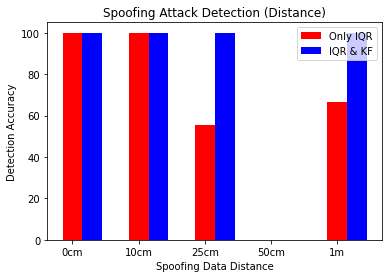

In [9]:
# Compare Accuracy (Distance)
x = np.arange(5)

plt.bar(x, acc_v_iqr, label = 'Only IQR', width = 0.3, color = 'red')
plt.bar(x+0.3, acc_v_iqr_kf, label = 'IQR & KF', width = 0.3, color = 'blue')
plt.xticks(x, spoof_distance)
plt.legend()
plt.title('Spoofing Attack Detection (Distance)')
plt.xlabel('Spoofing Data Distance')
plt.ylabel('Detection Accuracy')

print("Tag's Average Distance : 50cm")
plt.show()